## Part 1

---

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBRegressor
%matplotlib inline

In [4]:
df = pd.read_csv('wine-full.csv')
print(df.shape)
df.head()

(6497, 13)


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
# Dealing with str values
df = pd.get_dummies(df, columns=['type'], drop_first=True, dtype='int')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


In [6]:
df.isnull().sum()

fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
type_white               0
dtype: int64

The missing values are very few, so we can simply discard them without affecting the problem.

In [7]:
# Drop rows with empty values
df = df.dropna(axis=0)
print(df.shape)

(6463, 13)


In [8]:
inputs = df.drop(columns='quality')
targets = df['quality']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, train_size=0.8, random_state=0)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5170, 12) (5170,) (1293, 12) (1293,)


In [10]:
y_train.isnull().sum()

np.int64(0)

In [11]:
# Lasso
lasso = Lasso(alpha=0.001)
lasso.fit(x_train, y_train)

train_pred = lasso.predict(x_train)
test_pred = lasso.predict(x_test)

print('MAE in training set:', mean_absolute_error(train_pred, y_train))
print('MAE in test set:', mean_absolute_error(test_pred, y_test))
print('R-squared in training set:', r2_score(train_pred, y_train))
print('R-squared in test set:', r2_score(test_pred, y_test))

MAE in training set: 0.5727885258915913
MAE in test set: 0.5625385779876982
R-squared in training set: -1.4753424954095018
R-squared in test set: -1.3582839005202283


While Lasso appears to have a low error based on the MAE, the r-squared value indicates that it performs terribly on both the training and test sets. A negative r-squared means that the model performs worse than if it were to consistently predict the mean value of the distribution.

In [12]:
# Random Forest
forest = RandomForestRegressor(random_state=0)
forest.fit(x_train, y_train)

train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)

print('MAE in training set:', mean_absolute_error(train_pred, y_train))
print('MAE in test set:', mean_absolute_error(test_pred, y_test))
print('R-squared in training set:', r2_score(train_pred, y_train))
print('R-squared in test set:', r2_score(test_pred, y_test))

MAE in training set: 0.15903868471953578
MAE in test set: 0.4254524361948956
R-squared in training set: 0.9048131631598184
R-squared in test set: -0.0785092529882574


In [13]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}



grid_search = GridSearchCV(forest, param_grid, scoring='r2', cv=3)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='r2')

In [14]:
print('Best parameters:', grid_search.best_params_)

Best parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 150}


In [15]:
# Random Forest
forest = RandomForestRegressor(max_depth=30, min_samples_split=2, n_estimators=150, random_state=0)
forest.fit(x_train, y_train)

train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)

print('MAE in training set:', mean_absolute_error(train_pred, y_train))
print('MAE in test set:', mean_absolute_error(test_pred, y_test))
print('R-squared in training set:', r2_score(train_pred, y_train))
print('R-squared in test set:', r2_score(test_pred, y_test))

MAE in training set: 0.1579940407628254
MAE in test set: 0.42484554904378186
R-squared in training set: 0.9074646729555547
R-squared in test set: -0.0756482597610113


On the other hand, in the case of Random Forest, the model is overfitted even with the best parameters from the grid search.

In [16]:
lasso_coefficients = abs(lasso.coef_)
forest_weights = forest.feature_importances_

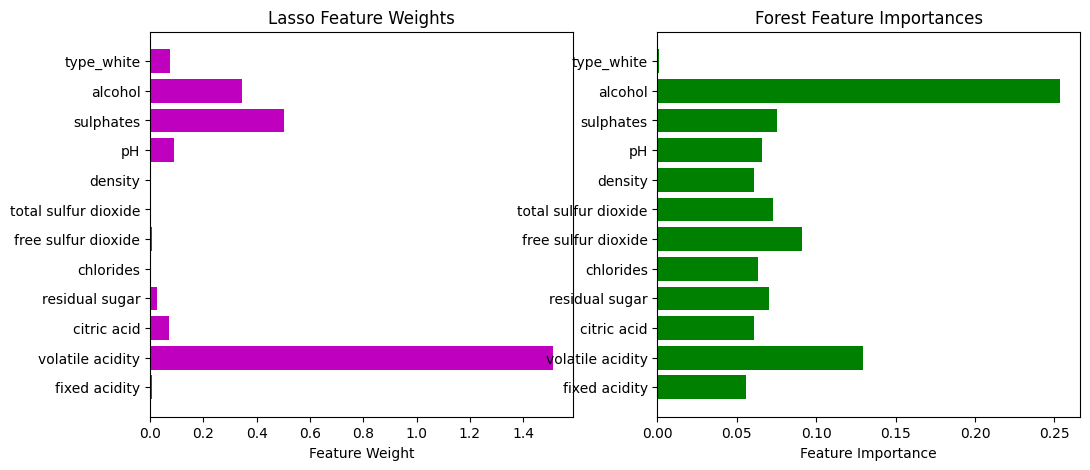

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.barh(x_train.columns, lasso_coefficients, color='m')
plt.title('Lasso Feature Weights')
plt.xlabel('Feature Weight')

plt.subplot(122)
plt.barh(x_train.columns, forest_weights, color='g')
plt.title('Forest Feature Importances')
plt.xlabel('Feature Importance')
plt.show()

In [18]:
r = permutation_importance(lasso, x_test, y_test, n_repeats=30, random_state=0)

importance = r.importances_mean
std_dev = r.importances_std

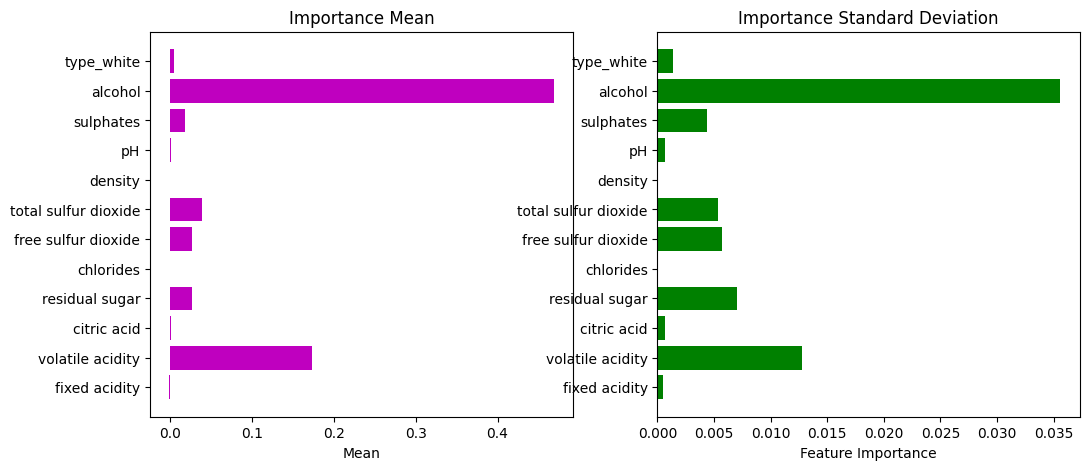

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.barh(x_train.columns, importance, color='m')
plt.title('Importance Mean')
plt.xlabel('Mean')

plt.subplot(122)
plt.barh(x_train.columns, std_dev, color='g')
plt.title('Importance Standard Deviation')
plt.xlabel('Feature Importance')
plt.show()

If we can analyze up to 3 features of the dataset, then we should use the most important features.

- **According to Lasso**, the most important features are `volatile acidity`, `sulphates`, and `alcohol`, in that order of importance.  
- **According to Random Forest**, the most important features are `alcohol`, `volatile acidity`, and `free sulfur dioxide`, respectively.  
- **According to permutation importance**, the most important features are `alcohol`, `volatile acidity`, and `total sulfur dioxide`.  

All three methods agree on the two features, `volatile acidity` and `alcohol`, but disagree on the third. We will also apply an **XGBoost model** to get an additional estimate of feature importance.

In [20]:
# XGBoost instance
xgb = XGBRegressor(n_estimators=60, max_depth=4, random_state=0)
xgb.fit(x_train, y_train)

train_pred = xgb.predict(x_train)
test_pred = xgb.predict(x_test)

print('MAE in training set:', mean_absolute_error(train_pred, y_train))
print('MAE in test set:', mean_absolute_error(test_pred, y_test))
print('R-squared in training set:', r2_score(train_pred, y_train))
print('R-squared in test set:', r2_score(test_pred, y_test))

MAE in training set: 0.41789525747299194
MAE in test set: 0.49662452936172485
R-squared in training set: 0.22964757680892944
R-squared in test set: -0.28818464279174805


In [21]:
feat_importance = xgb.feature_importances_

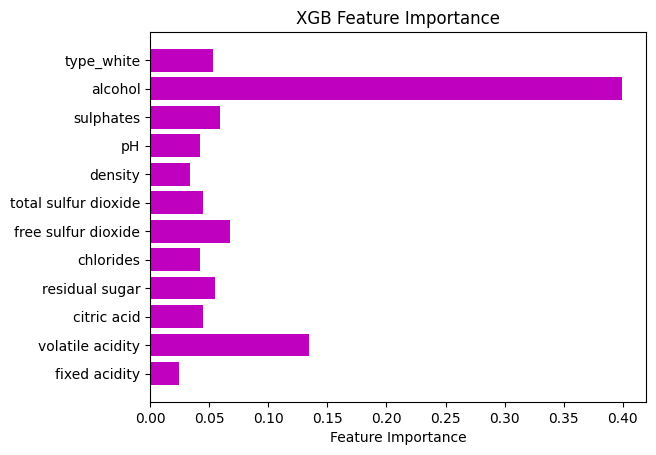

In [22]:
plt.barh(x_train.columns, feat_importance, color='m')
plt.title('XGB Feature Importance')
plt.xlabel('Feature Importance')
plt.show()

According to XGBoost, the most important features are `alcohol`, `volatile acidity`, and `free sulfur dioxide`.

As a final decision, we will take the majority vote of the 4 methods, meaning the most important features are `volatile acidity`, `alcohol`, and `free sulfur dioxide`.

## Part 2

---

In [ ]:
from keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


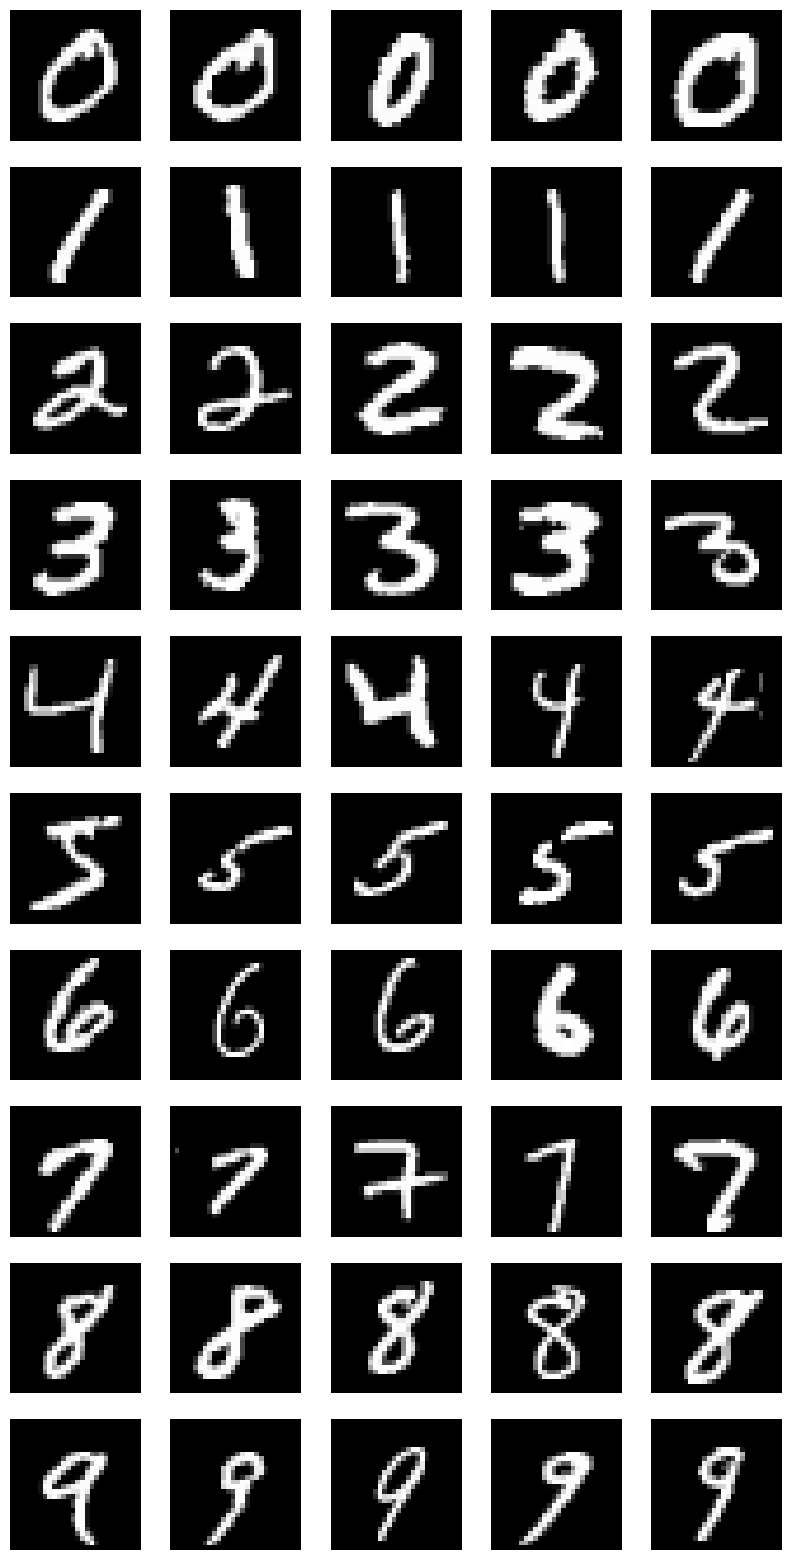

In [ ]:
fig, axes = plt.subplots(10, 5, figsize=(10,20))

for digit in range(10):
  count = 0
  digit_indeces = []
  for i in range(len(y_train)):
    if y_train[i] == digit:
      digit_indeces.append(i)
      count+=1
    if count >= 5:
      break

  for col in range(5):
    ax = axes[digit][col]
    ax.imshow(x_train[digit_indeces[col]], cmap='grey')
    ax.axis('off')


In [ ]:
print(np.ptp(x_train), np.ptp(x_test))

255 255


The features in this problem are the pixel brightness values (0-255), so we will normalize the data by simply scaling them into the range [0, 1].

All pixels are necessarily within this range, so there are no outliers to cause issues with this normalization. Additionally, the distribution of brightness for each pixel contains meaningful information (e.g., edge pixels are almost always 0, while pixels in the center of the image are often bright). By performing this normalization, we preserve the original distribution of each pixel's brightness.

In [ ]:
x_train = x_train/255
x_test = x_test/255

In [ ]:
print(np.ptp(x_train), np.ptp(x_test))

1.0 1.0


In [ ]:
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [ ]:
# Reshape arrays for be compatible for modeling
x_train = np.reshape(x_train, (len(x_train), -1))
x_test = np.reshape(x_test, (len(x_test), -1))
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [ ]:
%%time
k_values = [5, 15, 51, int(np.sqrt(60000))]
acc_scores = []

for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(x_train, y_train)

  pred = knn.predict(x_test)
  acc = accuracy_score(pred, y_test)
  acc_scores.append(acc)
  print(f'Accuracy score with k={k}:', acc)

Accuracy score with k=5: 0.9688
Accuracy score with k=15: 0.9633
Accuracy score with k=51: 0.9533
Accuracy score with k=244: 0.9241
CPU times: user 2min 24s, sys: 196 ms, total: 2min 24s
Wall time: 2min 25s


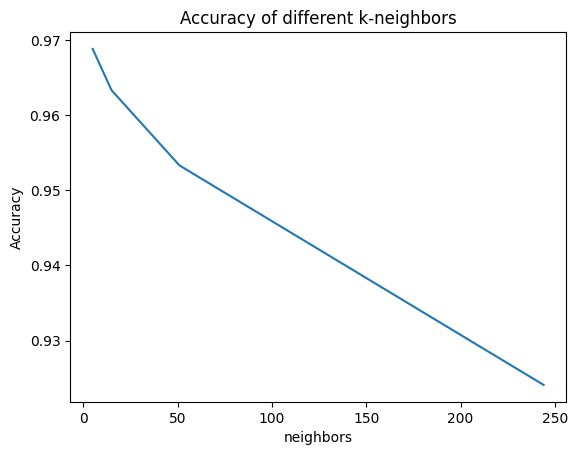

In [ ]:
plt.plot(k_values, acc_scores)
plt.title("Accuracy of different k-neighbors")
plt.xlabel('neighbors')
plt.ylabel('Accuracy')
plt.show()

As mentioned earlier, not all pixels are useful for the classifier, since those located at the edges will almost always be 0, while those toward the center will be part of the digits.

In [ ]:
pca = PCA(n_components=300)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [ ]:
print(x_train.shape, x_test.shape)
print(x_train_pca.shape, x_test_pca.shape)

(60000, 784) (10000, 784)
(60000, 300) (10000, 300)


In [ ]:
%%time
k_values = [5, 15, 51, int(np.sqrt(60000))]
acc_scores = []

for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(x_train_pca, y_train)

  pred = knn.predict(x_test_pca)
  acc = accuracy_score(pred, y_test)
  acc_scores.append(acc)
  print(f'Accuracy score with k={k}:', acc)

Accuracy score with k=5: 0.9693
Accuracy score with k=15: 0.9646
Accuracy score with k=51: 0.9542
Accuracy score with k=244: 0.9251
CPU times: user 1min 3s, sys: 165 ms, total: 1min 3s
Wall time: 1min 3s


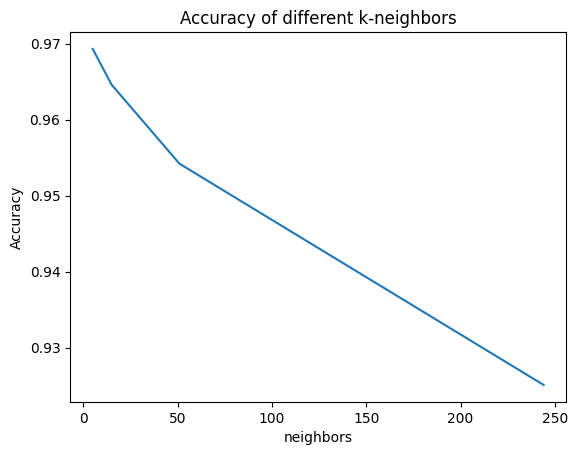

In [ ]:
plt.plot(k_values, acc_scores)
plt.title("Accuracy of different k-neighbors")
plt.xlabel('neighbors')
plt.ylabel('Accuracy')
plt.show()

When applying `fit_transform` to the training data, PCA learns the optimal eigenvectors and projects the training data to retain the maximum information. Then, using `transform`, we project the test data onto this new space. If we were to apply `fit` to the test data as well, PCA would learn the optimal eigenvectors to maximize information retention specifically for the test data, which would artificially inflate performance on the test set. This is incorrect because the test data should remain unseen; it is just as wrong as fitting a model directly on the test data and then making predictions for the test set.

The training time decreased, which is expected since we reduced the number of features from 768 to 300. As a result, the KNN algorithm has to compute fewer distances. The performance improved slightly, practically remaining the same. This happens because PCA essentially discards information that is irrelevant (for the training data).

However, this occurs in this specific case because the number of dimensions is not excessively high. If we had more dimensions (e.g., 1500+), in the case of KNN, dimensionality reduction should improve performance, as KNN is highly sensitive to the curse of dimensionality. As the number of dimensions increases, the concept of distance loses its meaning—all data points start to have similar distances to each other, and consequently, KNN struggles to distinguish neighbors.


In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
x_train_lda = lda.fit_transform(x_train, y_train)

In [ ]:
print(x_train.shape)
print(x_train_lda.shape)

(60000, 784)
(60000, 2)


In [ ]:
pred = lda.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       998
           1       0.97      0.89      0.93      1225
           2       0.79      0.92      0.85       891
           3       0.87      0.87      0.87      1017
           4       0.90      0.84      0.87      1059
           5       0.82      0.84      0.83       874
           6       0.89      0.91      0.90       941
           7       0.84      0.91      0.88       945
           8       0.81      0.80      0.80       990
           9       0.85      0.81      0.83      1060

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



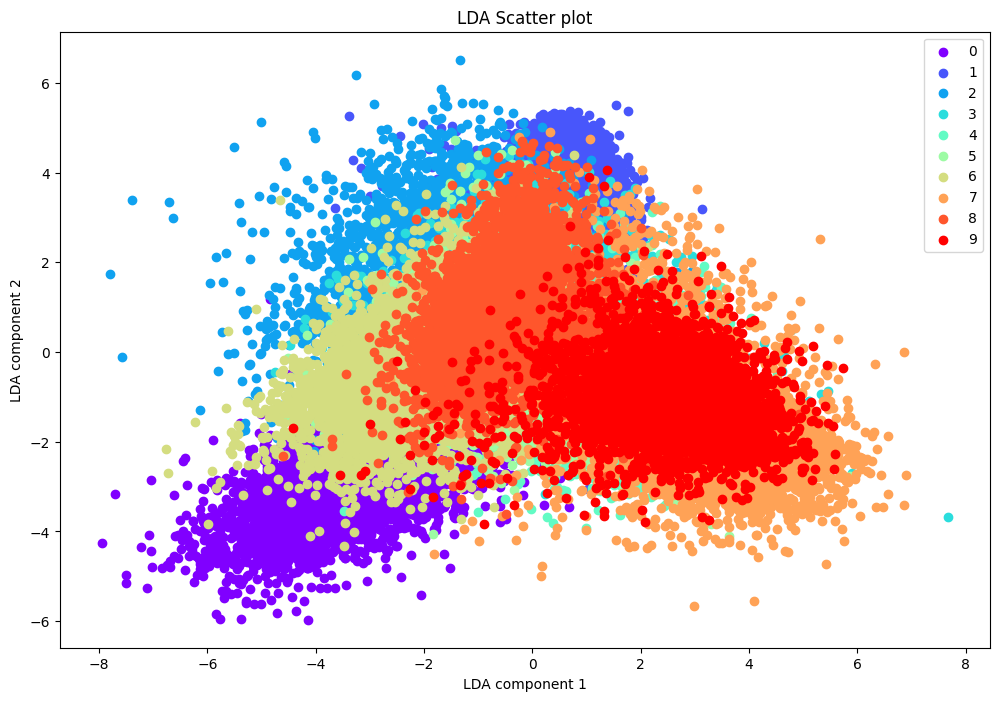

In [ ]:
plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0,1,10))

for digit in range(10):
  indeces = np.where(digit == y_train)
  plt.scatter(x_train_lda[indeces, 0], x_train_lda[indeces, 1], label=f'{digit}', color=colors[digit])

plt.title('LDA Scatter plot')
plt.xlabel('LDA component 1')
plt.ylabel('LDA component 2')
plt.legend()
plt.show()

It seems that, in general, LDA attempts to project the data in such a way that it becomes separable, and it succeeds to some extent. However, for example, if the data did not have labels, it would not be possible to separate them.